In [2]:
from fpla.utils import load_config
import fpla.h2h as h2h
import pandas as pd 
import re
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import json
import sqlite3

%load_ext autoreload 
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
config_path = Path('../sources-config.json')

config = load_config(config_path)
db_con = sqlite3.connect(config['db_connection'])

In [14]:
df = pd.read_sql("select * from fpl_h2h_league_2017", con=db_con)

# limit to first names
df['user_name'] = df['user_name'].apply(h2h.first_name).str.lower()
df['user_name_o'] = df['user_name_o'].apply(h2h.first_name).str.lower()

In [15]:
colour_dict = {
    'adam':'#b40000',
    'david':'#ff9000',
    'emad':'#7a36ae',
    'james':'#009600',
    'matt':'#3d3d3d',
    'tiago':'#0070c0'        
}

#### Rivalry radar plot
TODO make radar axis/grid lines flat

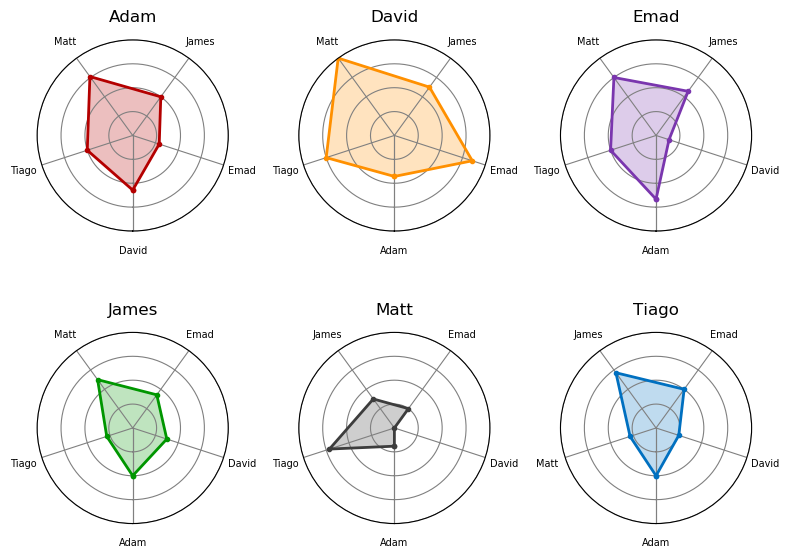

In [17]:
h2h.plot_rival_radar(df, colour_dict)

#### Season form plot

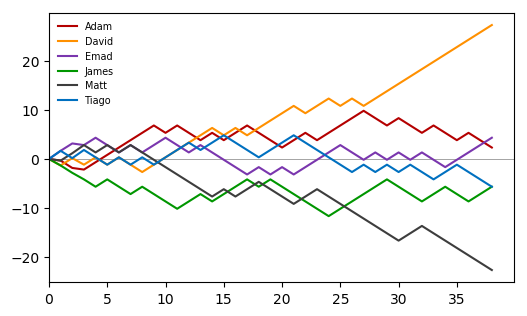

In [18]:
h2h.plot_form(df, colour_dict)

#### Biggest winning margin

In [19]:
df.loc[np.argsort(df.points - df.points_o).values].head()

,user_name_o,points,h2h_points,result,gw,user_name,points_o,total
53,emad,31,0,l,9,tiago,83,12
227,emad,40,0,l,38,tiago,84,51
216,emad,54,0,l,37,adam,95,59
39,emad,35,0,l,7,james,69,3
132,emad,49,0,l,23,adam,79,38


In [21]:
df_user = pd.read_sql("select * from fpl_user_2017", con=db_con)
df_picks = pd.read_sql("select * from fpl_user_picks_2017", con=db_con)
df_player = pd.read_sql("select * from fpl_player_2017", con=db_con)

df_user['user_name'] = df_user['user_name'].apply(h2h.first_name).str.lower()

#### Most points on bench

In [22]:
(df_user.loc[df_user.chip != 'bboost', ['gw', 'user_name', 'points_on_bench']]
        .groupby('user_name') 
        .points_on_bench
        .sum()
        .sort_values())

user_name
david    183
matt     188
tiago    192
james    213
adam     215
emad     237
Name: points_on_bench, dtype: int64

#### Most points spent on transfers

In [23]:
(df_user.loc[:, ['gw', 'user_name', 'gw_transfers_cost']]
        .groupby('user_name') 
        .gw_transfers_cost
        .sum().sort_values()) 

user_name
matt      24
adam      36
david     52
james     76
tiago    104
emad     124
Name: gw_transfers_cost, dtype: int64

Join users picks with player data

In [24]:
dfm = (df_user.merge(df_picks, on=['user_id', 'gw']) 
              .merge(df_player, on=['player_id', 'gw'], suffixes=['_user', '_player'])) 

#### Best Triple Captain

In [25]:
(dfm.loc[dfm.multiplier == 3, ["gw", "gw_match", "user_name", "player_name", "points_player"]]
    .groupby(["user_name","player_name"]) 
    .points_player.sum())

user_name  player_name      
adam       raheem sterling      3
david      harry kane           8
emad       romelu lukaku        8
james      harry kane           8
matt       christian eriksen    5
tiago      raheem sterling      3
Name: points_player, dtype: int64

#### "Best" Bench Boost
TODO find better way of measuring "best" other than assuming uplift is only from players initially on bench

In [26]:
(dfm.loc[(dfm.chip == 'bboost') & (dfm.position > 11), ["gw", "gw_match", "user_name", "player_name", "points_player"]]
    .groupby(["user_name"]) 
    .points_player.sum())

user_name
adam     12
david    14
emad     26
james    11
matt     16
tiago    28
Name: points_player, dtype: int64

Simulating points achieved in the next gameweek for a fixed lineup of picks

In [27]:
dfmn = (df_user.assign(next_gw=df_user.gw + 1)
               .merge(df_picks, on=['user_id', 'gw'])
               .merge(df_player, left_on=['player_id', 'next_gw'], right_on=['player_id', 'gw'], suffixes=['_user', '_player'])
               .groupby(['user_name', 'next_gw'])
               .points_player.sum().reset_index())

#### Best Free Hit

In [28]:
(dfm.loc[dfm.chip == 'freehit'] 
   .groupby(['user_name', 'gw'])
   .points_player.sum().reset_index()
   .merge(dfmn, left_on=['user_name', 'gw'], right_on=['user_name', 'next_gw'], suffixes=['_gw', '_next_gw']))

,user_name,gw,points_player_gw,next_gw,points_player_next_gw
0,adam,22,65,22,51
1,david,35,61,35,6
2,emad,31,89,31,40
3,james,12,65,12,43
4,matt,31,80,31,40
5,tiago,31,79,31,33


#### "Best" Wildcard
TODO considering measuring wildcard performance over multiple weeks

In [29]:
(dfm.loc[dfm.chip == 'wildcard'] 
   .groupby(['user_name', 'gw'])
   .points_player.sum().reset_index()
   .merge(dfmn, left_on=['user_name', 'gw'], right_on=['user_name', 'next_gw'], suffixes=['_gw', '_next_gw']))

,user_name,gw,points_player_gw,next_gw,points_player_next_gw
0,adam,3,61,3,62
1,adam,28,41,28,37
2,david,8,61,8,35
3,david,32,63,32,40
4,emad,2,39,2,41
5,emad,35,53,35,17
6,james,4,31,4,66
7,james,27,87,27,70
8,matt,7,73,7,41
9,matt,29,56,29,35
